# DistilBERT + veći dataset


In [ ]:
!pip install datasets

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from transformers import TrainingArguments, Trainer

## Učitavanje podataka

- sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)
- "Emotions" dataset https://www.kaggle.com/datasets/nelgiriyewithana/emotions/data
- br. redaka: 416809
- br. stupaca: 3 (unnamed, text, label)

In [ ]:
df = pd.read_csv("text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}

df['label'] = df['label'].map(id2label)
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,fear
1,1,ive enjoyed being able to slouch about relax a...,sadness
2,2,i gave up my internship with the dmrg and am f...,fear
3,3,i dont know i feel so lost,sadness
4,4,i am a kindergarten teacher and i am thoroughl...,fear


In [ ]:
print(df.shape)

(416809, 3)


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
text,0
label,0


--> nema null-redaka

In [ ]:
# brisanje nepotrebnog stupca
df.drop("Unnamed: 0", axis=1, inplace=True)

## Distribucija podataka

Koja je raspodjela podataka? Ima li neke kategorije značajno više
--> najviše ima joy (1) i sadness (0)

In [ ]:
df["label"].value_counts()

,count
label,
joy,141067
sadness,121187
anger,57317
fear,47712
love,34554
surprise,14972


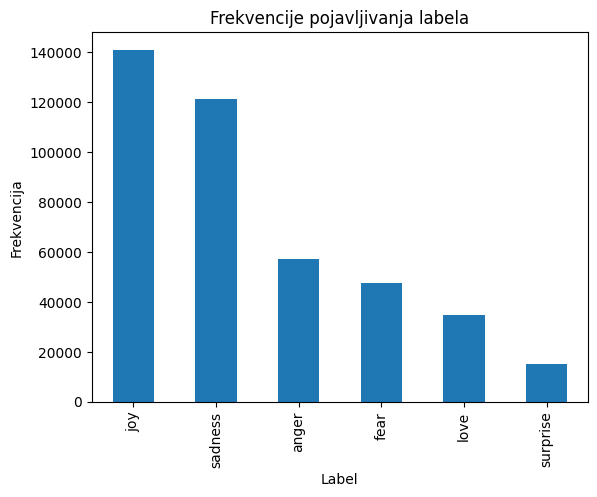

In [ ]:
frequencies = df['label'].value_counts()
frequencies.plot(kind='bar')

plt.xlabel('Label')
plt.ylabel('Frekvencija')
plt.title('Frekvencije pojavljivanja labela')
plt.show()

## Vizualizacija podataka - WordCloud

....

## Priprema podataka

In [ ]:
def remove_redundant(df):
    # 1. Brisanje URL-ova
    df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)

    # 2. Uklanjanje suvišnih razmaka
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

    # 3. Uklanjanje brojeva
    df['text'] = df['text'].str.replace(r'\d+', '', regex=True)

    return df

In [ ]:
df = remove_redundant(df)

## Podjela na train, validation, test skupove

Podjela podataka na train i temp (koji će se dalje podijeliti na val i test)
- 80% podataka ide u train, a 20% ide u temp.

Stratifikacija osigurava ravnomjernu raspodjelu klasa (labela) u oba skupa.

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
# Daljnja podjela temp skupa na val i test - 50% od temp skupa ide u val, a preostalih 50% ide u test.
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print("Test size:", test_df.shape)

Train size: (333447, 2)
Validation size: (41681, 2)
Test size: (41681, 2)


train_df - za treniranje modela (model uči iz podataka u ovom skupu kako bi optimizirao svoje težine)

val_df - za evaluaciju modela tijekom treniranja (za praćenje performansi modela tijekom treniranja)

test_df - za konačnu evaluaciju modela nakon treniranja (potpuno nevidljiv modelu tijekom treniranja i validacije)

## Tokenizacija

Koristi se tokenizator za DistilBERT - pretvara tekst u niz numeričkih ID-jeva (tokena) koje model može obraditi.


In [ ]:
from transformers import AutoTokenizer
model_name = "distilbert-base-uncased" # model path for DistilBERT

# loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(df, label2id):

    # tokenizacija stupca "text"
    tokenized_inputs = tokenizer( # koristi se distilBERT tokenizer
        df['text'], # sto treba tokenizirati
        padding='longest', # dodaje 0 gdje treba da svi inputi budu iste duljine
        truncation=True, # reže preduge rečenice (>512 tokena)
        max_length=512, # osigurava da ništa ne prelazi 512 tokena (maks. za BERT)
        return_tensors='pt' # vraća podatke kao PyTorch tenzore (torch.Tensor) umjesto Python lista
    ) # vraca rjecnik s kljucevima 'input_ids', 'attention_mask'

    # dodaje novi kljuc "label" u tokenized_inputs
    tokenized_inputs["label"] = [label2id.get(emotion, -1) for emotion in df["label"]]

    return tokenized_inputs

tokenized_inputs je rječnik koji sadrži podatke za unos u model.

--> Ključ 'input_ids' sadrži listu listi, gdje je svaka unutarnja lista niz numeričkih ID-jeva koji predstavljaju tokene rečenice

npr {

  'input_ids': [[101, 2023, 2003, 1037, 2742, 102, 0, 0, 0], ...],

  'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0], ...],

  'label': [1, 3, 0, 2, ...]

}

In [ ]:
# Pretvara običan Pandas DataFrame (train_df) u Hugging Face Dataset objekt
train_dataset = Dataset.from_pandas(train_df)

In [ ]:
# Prolazi kroz train_dataset u batchevima i na svaki batch primjenjuje preprocess_function,
# koja tokenizira tekstove i dodaje numeričke label-e
train_dataset = train_dataset.map(lambda x: preprocess_function(x, label2id), batched=True)

Map:   0%|          | 0/333447 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset[0])

{'text': 'i just look at myself and feel disgusted', 'label': 3, '__index_level_0__': 405091, 'input_ids': [101, 1045, 2074, 2298, 2012, 2870, 1998, 2514, 17733, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
val_dataset = Dataset.from_pandas(val_df)
val_dataset = val_dataset.map(lambda x: preprocess_function(x, label2id), batched=True)

test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(lambda x: preprocess_function(x, label2id), batched=True)

Map:   0%|          | 0/41681 [00:00<?, ? examples/s]

Map:   0%|          | 0/41681 [00:00<?, ? examples/s]

## Fine-Tuning

In [ ]:
# uzima postojeći (pretrained) model DistilBERT
# dodaje mu sloj za klasifikaciju - potreban za fine-tuning u zadacima klasifikacije teksta
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, # "distilbert-base-uncased"
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### DistilBert
fine-tuning = proces prilagodbe modela specifičnom zadatku, kao što je klasifikacija emocija, nakon što je model prethodno treniran na velikim skupovima podataka za generalno razumijevanje jezika.
- običan (prije fine-tuninga) DistilBERT je naučo obične jezične karakteristike (sposobnost razumijevanja sintakse, semantike i konteksta riječi), ima generalno znanje o jeziku
- manja, brža i lakša verzija BERT-a, ali zadržava većinu performansi - 6 slojeva umjesto 12
- DistilBERT postiže cca 97% točnosti koju postiže BERT na GLUE benchmark zadacima (standardizirani testovi za NLP)

## Metrike

- ACCURACY - koliko tocnih predikcija u odnosu na ukupni broj odgovora
- PRECISION - koliko je precizno za odredenu kategoriju: br. tocnih te kategorije / ukupno sto je model rekao da je te kategorije
    -   TP / (TP + FP = uk. sto je rekao da je poz)
    -   based on predictions - gledam predikcije i tu specificnu kategoriju u predikcijama
    - Kad model kaže "ovo je joy", koliko često je u pravu?
- RECALL - br. tocno predvidenih / uk. istinski pozitivnih
    -    TP / (TP + FN)
    -   based on truth - gledam sve koji su zapravo u toj kategoriji i onda onoliko koliko sam tocno pogodila
- F1_SCORE - harmonijska sredina od precision i recall
- AUC_SCORE -

In [ ]:
# izračunava accuracy, F1 score, precision, and recall
# p = tuple: predvidanja (logit, "sirove" izlazne vrijednosti iz modela (prije softmaxa)) i stvarne oznake (labels)
def compute_metrics(p):
    logits, labels = p

    # sve vrijednosti izmedu 0 i 1, zbroj = 1
    softmax = torch.nn.Softmax(dim=1);
    probs = softmax(torch.tensor(logits))

    # uzmi najvjerojatniju --> predvidena klasa
    preds = probs.argmax(axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),  # Accuracy metric
        "precision": precision_score(labels, preds, average='weighted'),  # Precision score with weighted average
        "recall": recall_score(labels, preds, average='weighted'),  # Recall score with weighted average
        "f1_score": f1_score(labels, preds, average='weighted'),  # F1 score with weighted average for imbalanced data
        "auc_score": roc_auc_score(labels, probs, average="macro", multi_class="ovr")
    }

## Argumenti za treniranje

In [ ]:
# postavljanje hiperparametara
lr = 2e-5 # learning rate, standardno
batch_size = 16     # koliko se podataka obraduje odjednom
num_epochs = 3      # koliko puta prolazimo kroz citav skup za treniranje
weight_decay = 0.01 # sprječava prenaučenost penaliziranjem velikih težina

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # evaluacija (na validacijskom skupu) se radi na kraju svake epohe
    save_strategy="epoch",
    learning_rate=lr, # stopa promjene kojom model ažurira svoje težine tijekom treniranja
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay, # sprječava da težine u modelu postanu prevelike (može značiti da je naučio podatke napamet)
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_score",
    greater_is_better=True,
)

## Treniranje

In [ ]:
# inicijalizacija modela
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-39-9b0882966b7d>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print(f"Training {model_name}...")
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training distilbert-base-uncased...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: patricija-marijanovic955 (patricija-marijanovic955-faculty-of-electrical-engineering) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Auc Score
1,0.091000,0.097067,0.942828,0.950377,0.942828,0.944143,0.997709


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score,Auc Score
1,0.091000,0.097067,0.942828,0.950377,0.942828,0.944143,0.997709
2,0.092100,0.093616,0.942036,0.948402,0.942036,0.943505,0.997838
3,0.078500,0.097399,0.942708,0.951538,0.942708,0.944225,0.997787


TrainOutput(global_step=62523, training_loss=0.09989164264459553, metrics={'train_runtime': 8732.0644, 'train_samples_per_second': 114.56, 'train_steps_per_second': 7.16, 'total_flos': 2.3023258297372692e+16, 'train_loss': 0.09989164264459553, 'epoch': 3.0})

## Evaluacija modela

In [ ]:
# predictions on the test dataset with fine-tuned model
predictions_finetuned_model = trainer.predict(test_dataset)
preds_finetuned = predictions_finetuned_model.predictions.argmax(axis=1) # uzmi najvece vrijednosti

# evaluation metrics (accuracy, precision, recall, and F1 score)
eval_results_finetuned_model = compute_metrics((predictions_finetuned_model.predictions, test_dataset["label"]))

In [ ]:
print(eval_results_finetuned_model)

{'accuracy': 0.9427796837887766, 'precision': 0.9519519497759723, 'recall': 0.9427796837887766, 'f1_score': 0.9443593735422493, 'auc_score': np.float64(0.9979390921515418)}


In [ ]:
my_sentence = "I can't stand this anymore, i'm furious"
dummy_emotion = "joy"  # mora biti nešto iz label2id

# Pandas DataFrame
df = pd.DataFrame({
    "text": [my_sentence],
    "emotion": [dummy_emotion]
})

# HuggingFace Dataset
sentence_dataset = Dataset.from_pandas(df)

# Prilagodi preprocess function za samo predikciju (bez labela)
def preprocess_function_for_inference(df, label2id):
    # Samo tokenizacija, bez dodavanja labela
    tokenized_inputs = tokenizer(
        df['text'],
        padding='longest',
        truncation=True,
        max_length=512,
        return_tensors='pt'  # vraća podatke kao PyTorch tenzore
    )
    return tokenized_inputs

# Koristi mapiranje samo za tekst
sentence_dataset = sentence_dataset.map(lambda x: preprocess_function_for_inference(x, label2id), batched=True)

# Predikcija
prediction = trainer.predict(sentence_dataset)

# Uzmi klasu s najvećim scoreom
predicted_class = prediction.predictions.argmax(axis=1)[0]

# Ako imaš id2label mapu
predicted_label = id2label[predicted_class]
print(f"Predikcija emocije: {predicted_label}")

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Predikcija emocije: anger


In [ ]:
# spremanje modela
# Spremi cijeli model s treniranim parametrima
trainer.save_model("./spremljeni_model")
tokenizer.save_pretrained("./spremljeni_model")

('./spremljeni_model/tokenizer_config.json',
 './spremljeni_model/special_tokens_map.json',
 './spremljeni_model/vocab.txt',
 './spremljeni_model/added_tokens.json',
 './spremljeni_model/tokenizer.json')